In this notebook we will implement classical AlexNet-8 model to identify the breed of dogs. This notebook is based on Udacity's [Deep Learning Nanodegree project](https://github.com/udacity/deep-learning-v2-pytorch/tree/master/project-dog-classification). There is some extra task in the Nanodegree project but we will limit ourselves to classify the input dog images into its breed. The dataset is provided at [dogImages](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).

AlexNet-8 employ 8 learned layers out of which 5 are convolution layer and 3 are linear layers. More details about the AlexNet is available at paper:- [Krizhevsky](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)


In [1]:
## Load necessary packages
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

test_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

In [6]:
data_dir = "dogImages/"
train_data = datasets.ImageFolder(data_dir + "train/", transform = train_transform)
valid_data = datasets.ImageFolder(data_dir + "valid/", transform=train_transform)
test_data = datasets.ImageFolder(data_dir + "test/", transform = test_transform)

print("Number of Training Data: {}".format(len(train_data)))
print("Number of Testing Data: {}".format(len(test_data)))
print("Number of Validating Data: {}".format(len(valid_data)))


Number of Training Data: 6680
Number of Testing Data: 836
Number of Validating Data: 835


In [7]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)


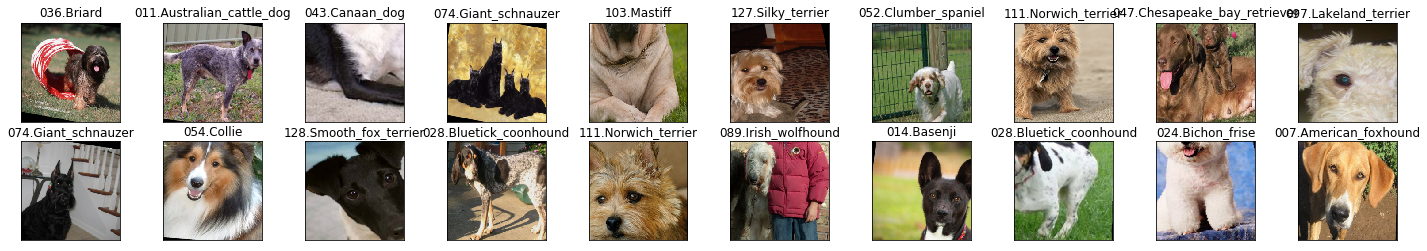

In [8]:
 # obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
train_on_gpu = True if torch.cuda.is_available() else False
if train_on_gpu:
    images = images.cuda()


# plot the images in the batch, along with predicted labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    img = images.cpu()[idx]
    img = img * 0.5 + 0.5
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    ax.set_title(test_data.classes[labels[idx].item()])


In [9]:
class AlexNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(384 * 5 * 5, 4096) 
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 133)
        
        
        
        self.pool = nn.MaxPool2d(kernel_size=3,stride=2)
        
        self.dropout = nn.Dropout(p=0.25)
    
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.pool(x)
        
        
        x = x.view(-1, 9600)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        
        return x
        


In [10]:
alexnet8 = AlexNet()
alexnet8

AlexNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=9600, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=133, bias=True)
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [11]:
if train_on_gpu:
    alexnet8 = alexnet8.cuda()

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet8.parameters(), lr=0.001)

In [13]:
n_epochs = 2 ## Increase it to more
train_losses = []
valid_losses = []
valid_loss_min = np.inf

for e in range(n_epochs):
    train_loss = 0
    valid_loss = 0
    
    alexnet8.train()
    
    for img, label in train_loader:
        
        if train_on_gpu:
            img = img.cuda()
            label = label.cuda()
        
        optimizer.zero_grad()
        
        predicted_label = alexnet8(img)
        loss = criterion(predicted_label, label)
        loss.backward()
        optimizer.step()
        train_loss = train_loss + loss.item()
    
    alexnet8.eval()
    
    for img, label in valid_loader:
        
        if train_on_gpu:
            img = img.cuda()
            label = label.cuda()
        predicted_label = alexnet8(img)
        loss = criterion(predicted_label, label)
        
        valid_loss = valid_loss + loss.item()
    
    train_loss = train_loss/len(train_loader)
    train_losses.append(train_loss)
    valid_loss = valid_loss/len(valid_loader)
    valid_losses.append(valid_loss)
    
    print("Epoch: {} Train Loss: {} Valid Loss: {}".format(e+1, train_loss, valid_loss))
    
    if valid_loss < valid_loss_min:
        print("Validation Loss Decreased From {} to {}".format(valid_loss_min, valid_loss))
        valid_loss_min = valid_loss
        torch.save(alexnet8.state_dict(), "alexnet8_may_10.pth")
        print("Saving Best Model")
    
        
    


Epoch: 1 Train Loss: 29.204321806368075 Valid Loss: 4.8903498296384456
Validation Loss Decreased From inf to 4.8903498296384456
Saving Best Model
Epoch: 2 Train Loss: 4.890539306202574 Valid Loss: 4.8903498296384456
